In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# simple 1D conduction example
alpha = 2.30e-05
dx = 0.01
dt = 2.0
boilingPoint = 100
neutralTemp = 0
length = 0.1
burningTime = 0 # sec
burningSpeed = 0

In [3]:
def initial_frame():
    zeros = np.full(int(length//dx)+1, neutralTemp) # last box won't change
    zeros[0] = boilingPoint
    return pd.DataFrame(zeros, dtype=float).T

In [4]:
def next_frame(frameBefore):
    nextFrame = frameBefore.copy()
    for i, box in enumerate(frameBefore):
        if box == boilingPoint: continue
        elif i == len(frameBefore)-1: break
        nextFrame[i] = frameBefore[i] + (frameBefore[i+1]-2*box+frameBefore[i-1])*alpha*dt/dx**2
    return nextFrame

def next_step(frame):
    lastFrame = frame.iloc[-1].copy()
    frameToAppend = pd.DataFrame(next_frame(lastFrame)).T 
    return pd.concat([frame, frameToAppend])

In [5]:
maxSteps = 100
data = initial_frame()
for step in range(maxSteps):
    data = next_step(data)
data = data.reset_index(drop=True)
data['time'] = data.index.to_frame()*dt

In [6]:
#data

In [7]:
toPlot = data.loc[(data['time']==0) | (data['time']==20) | (data['time']==40) | (data['time']==60) | (data['time']==200)]
toPlot = toPlot.drop(['time'], axis=1)
toPlot = toPlot.rename(columns=lambda x:x*dx*1000, index=lambda y: y*dt)

In [8]:
#toPlot

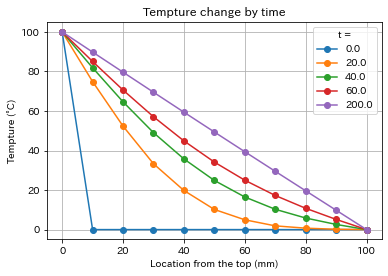

In [9]:
plt.plot(toPlot.T, marker='o')
plt.title('Tempture change by time')
plt.xlabel('Location from the top (mm)')
plt.ylabel('Tempture (°C)')
plt.legend(title='t =', labels=toPlot.index.to_list())
plt.grid(True)
plt.show()

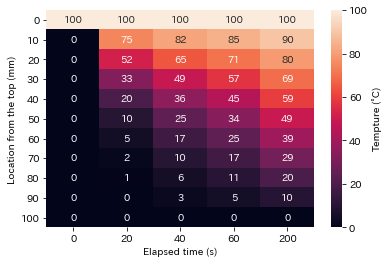

In [12]:
ax = sns.heatmap(toPlot.T, annot=True, fmt='.0f', cbar_kws={'label': 'Tempture (°C)'})
ax.set(ylabel='Location from the top (mm)', xlabel='Elapsed time (s)',
       yticklabels=[int(x) for x in toPlot.columns.to_list()],
       xticklabels=[int(y) for y in toPlot.index.to_list()])
plt.show()

In [18]:
# https://www.ohm.jp/media/tech_cooling204.pdf
# params for paraffin, main ingredients for candles
density = 880 # kg/m^3
specificHeatCapacity = 2.180 * 10**3 # J/(kg*K) = 2.180kJ/(kg*K)
thermalConductivity = 0.1260 # W/(m*K) = J/(s*m*K)
alpha = thermalConductivity/(density*specificHeatCapacity) # m^2/s
print('alpha: {}'.format(alpha))

dx = 0.001 # m
dt = 5.0 # sec
# https://anzeninfo.mhlw.go.jp/anzen/gmsds/8002-74-2.html
boilingPoint = 200 # constant tempture of the heat source
neutralTemp = 25 # initial tempture of the candle

# candle lenth and burning time: http://www.sakura-rousoku.jp/products/nensyou.html
# using "3-go" candle
length = 0.147 # total length of the candle in m
length = 0.1501 # to make xlabels clearer
print('num of box: {}'.format(length//dx))
burningTime = 1*60*60 + 40*60 # sec
print('burningTime: {}'.format(burningTime))
burningSpeed = length/burningTime # m/sec
#burningSpeed = 0
print('burningSpeed: {}'.format(burningSpeed))

alpha: 6.567973311092577e-08
num of box: 150.0
burningTime: 6000
burningSpeed: 2.5016666666666667e-05


In [14]:
def next_frame(frameBefore, flamePos):
    nextFrame = frameBefore.copy()
    for i, box in enumerate(frameBefore):
        if i*dx <= flamePos: 
            nextFrame[i] = boilingPoint
            continue
        elif box == boilingPoint: continue
        elif i == len(frameBefore)-1: break
        nextFrame[i] = frameBefore[i] + (frameBefore[i+1]-2*box+frameBefore[i-1])*alpha*dt/dx**2
    return nextFrame

def next_step(frame, flamePos):
    lastFrame = frame.iloc[-1].copy()
    frameToAppend = pd.DataFrame(next_frame(lastFrame, flamePos)).T 
    return pd.concat([frame, frameToAppend]), flamePos

In [15]:
#burningTime//dt

In [19]:
#maxSteps = 1000
maxSteps = int(burningTime//dt)
data = initial_frame()
flamePos = 0
for step in range(maxSteps):
    flamePos += burningSpeed*dt
    #print(flamePos)
    data, flamePos = next_step(data, flamePos)
    #data = next_step(data)
data = data.reset_index(drop=True)
data['time'] = data.index.to_frame()*dt

In [20]:
#data

In [21]:
toPlot = data.loc[data['time']%(data['time'].max()//5)==0]
toPlot = toPlot.drop(['time'], axis=1)
toPlot = toPlot.rename(columns=lambda x: x*dx*1000, index=lambda y: y*dt)

In [22]:
#toPlot

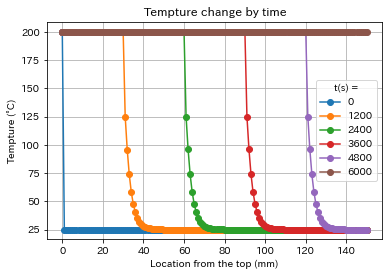

In [23]:
#plt.figure(figsize=(9, 6))
plt.plot(toPlot.T, marker='o')
plt.title('Tempture change by time')
plt.xlabel('Location from the top (mm)')
plt.ylabel('Tempture (°C)')
plt.legend(title='t(s) =', labels=[int(i) for i in toPlot.index.to_list()])
plt.grid(True)
plt.show()

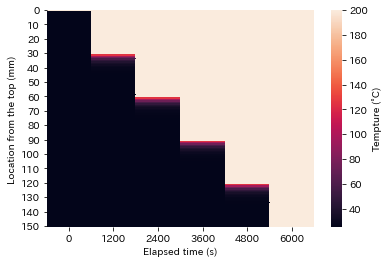

In [24]:
ax = sns.heatmap(toPlot.T, cbar_kws={'label': 'Tempture (°C)'})
ax.set(ylabel='Location from the top (mm)', xlabel='Elapsed time (s)',
       xticklabels=[int(y) for y in toPlot.index.to_list()])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

In [25]:
# https://sagami3.hatenadiary.org/entry/20130218
# 50°C is said that we can keep grabbing for a while...

data2 = data.drop(['time'], axis=1)
def safe_distance(time):
    bottomFlameBox = data2.where(data2 == boilingPoint).loc[time//dt].dropna().tail(1).index[0]
    bottomFlameHeight = (bottomFlameBox+1)*dx
    #print(bottomFlameHeight)
    topSafeHeight = data2.where(data2 < 50).loc[time//dt].dropna().head(1)
    if len(topSafeHeight) == 0: topSafeHeight = bottomFlameHeight
    else: topSafeHeight = topSafeHeight.index[0]*dx
    #print(topSafeHeight)
    return topSafeHeight - bottomFlameHeight

In [26]:
# this will take some time...
safeList = [safe_distance(i)*10**3 for i in range(burningTime)]

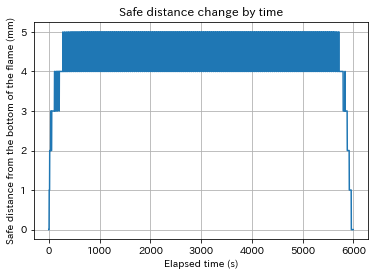

In [28]:
plt.plot(safeList)
plt.title('Safe distance change by time')
plt.xlabel('Elapsed time (s)')
plt.ylabel('Safe distance from the bottom of the flame (mm)')
plt.grid(True)
plt.show()